___

# Detection of COVID-19 and Viral Pneumonia using chest X-Rays

___

## Table of Contents

1. [Problem Statement](#section1)<br>
2. [Dataset Overview](#section2)<br/>
3. [Importing Libraries](#section3)<br/>
4. [Preparing Training and Test Sets](#section4)<br/>
5. [Creating Custom Dataset](#section5)<br/>  
6. [Image Transformation](#section6)<br/>
7. [Prepare DataLoader](#section7)<br/>  
8. [Data Visualization](#section8)<br/>  
9. [Creating the Model](#section9)<br/>  
10. [Training the Model](#section10)<br/> 
11. [Final Results](#section11)<br/>  
12. [Conclusion](#section12)<br/>  
13. [Ackowledgements](#section13)<br/>  

___

<a id='section1'></a>
## 1. Problem Statement

In this project, we will be using the COVID-19 Radiography Dataset from Kaggle. This dataset contains images of chest X-rays. These X-rays are categorized into 3 categories:
    1. Normal
    2. Viral Pneumonia
    3. COVID-19

We will be using the ResNet-18 model to perform image classification in order to predict if a given X-ray is COVID-19 positive, normal or contains viral pneumonia. We will use the pretrained version of ResNet-18 in our case and we will observe our results.

Lastly, we will use pickle to save our model so that it can be deployed at a later stage as a stand-alone web application or as part of another application.

___

<a id='section2'></a>
## 2. Dataset Overview

- The COVID-19 Radiography Dataset contains __2905__ sample images of chest X-rays.
- These images are subdivided into COVID-19, Viral Pneumonia and normal classes. There are a total of __1345__ Viral Pneumonia images, __1341__ Normal images and __219__ COVID-19 images.
- All the images are in Portable Network Graphics (PNG) file format and resolution is 1024-by-1024 pixels, which can be easily converted to 224-by-224 or 227-by-227 pixels typically required by the popular Convolutional Neural Networks (CNNs).
- __Ackowledgement__ : M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

___

<a id='section3'></a>
## 3. Importing Libraries

In [5]:
%matplotlib inline

import os           # Used to access file system and create or rename directories
import shutil       # Used to manupilate file system and create a test folder
import random
import torch
import torchvision       # Torch vision library in order to transform our images and use the Resnet18 pretrained model
import numpy as np

from PIL import Image     # Pillow library in order to import the Image class and use instances to handle the images
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version',torch.__version__)

Using PyTorch version 1.4.0


___

<a id='section4'></a>
## 4. Preparing Training and Test Sets

In [7]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

- In the above cell, we first settle on the different classes by which we are going to classify our pictures.
- We then create a directory called 'test' and add 30 images of each class to them.
- We will use this directory in order to validate our predictions.

___

<a id='section5'></a>
## 5. Creating Custom Dataset

In [8]:
class XRayImageDataset(torch.utils.data.Dataset):
    def __init__(self,image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name}')
            return images
        
        self.images = {}
        self.class_names=['normal','viral','covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
        
        self.image_dirs = image_dirs
        self.transform = transform
    
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self,index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) # we divide by the no. of items in the class and get modulus so that
                                                     # we dont overshoot the index of classes with less items. ex: a class only has 300
                                                     # but if we pass index 300 then it will be over the no of items. 300 % 200 = 100 so 100 will be chosen as index
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name) # Joining images directory and its name for full path
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

- torch.utils is used to create a class of type Dataset.
- We will define all our primary functions to initialize, create the dataset and convert the images into a format that can be used by the Resnet18 model.
- The init method will be called when the class XRayImageDataset is initialized. Within it, we have the get_images function which is used to return all images that match the class name passed as a parameter to the function.
- In the __init__ method, we loop through all the class names and get the images within each of the calsses. These images are saved to the self.images variable.
- We also have the __len__ function which returns the total number of images across all classes.
- Lastly, we have the __getitem__ function to which we pass an index. This index is used to return an image from a random class at that index.
- ResNet18 requires that we use 3 channels.
- We covert the image to RGB because most of these X-ray images are actually black and white. If we were to create a CNN from scratch then we wouldnt have to use RGB, we would just use channel value as 1 for black and 0 for white.
- Since we are using the pretrained ResNet18 model, we must use 3 channels as that is how it accepts input.

___

<a id='section6'></a>
## 6. Image Transformations

In [27]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                   std=[0.229,0.224,0.225])
    # We define 3 different values in mean and std, 1 for each channel that we have (RGB)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                   std=[0.229,0.224,0.225])
])


- First the training transform is created. We resize the image to a size that is acceptable for Resnet18. Then we apply image augmentation by randomly flipping images horizontally.
- The image is then converted to a tensor and further it is normalized.
- The values used for normalizing are the values the model was trained on with the ImageNet dataset.
- Normalize performs image = (image - mean) / std. To undo this Normalization we need to perform image = ((image * std) + mean) at a later stage.
- Image augmentation is only applied to the training set so our test transform is created almost the same way except we do not apply normalization to it.

___

<a id='section7'></a>
## 7. Prepare DataLoader

In [10]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = XRayImageDataset(train_dirs, train_transform)

Found 1311 normal
Found 1315 viral
Found 189 covid


In [11]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = XRayImageDataset(test_dirs,test_transform)

Found 30 normal
Found 30 viral
Found 30 covid


- We create a dictionary for the train and test directories. We need these directories as we will pass them into our XRayImageDataset class along with the transforms we have just created.
- Passing these values into our XRayImageDataset will call the init method etc.

In [12]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 470
Number of test batches 15


- In the above code cell, we set a batch size and create a dataloader using the torch library. One for the training set and one for the test set.

___

<a id='section8'></a>
## 8. Data Visualization

In [13]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0)) 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean # This is to revert the normalization changes we made to the image and get the pixel values back to their original values
        image = np.clip(image, 0., 1.) # Clip image between 0 and 1
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        # Shows prediction in red if wrong and green if right
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

- A basic function is created that will display images based on the images and labels passed into it.
- We transpose the image because when we use Resnet18, the index 0 actually contains the channel information. We would like to have the last index i.e index 2 to represent the channel instead.
- This means index 0 and 1 will represent the height and width information of the image.
- We also need to revert the normalization we used during transformation phase so that the images that are returned are the same as the original images.

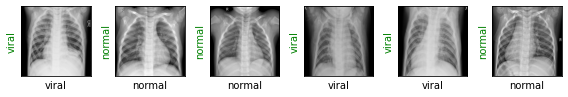

In [14]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

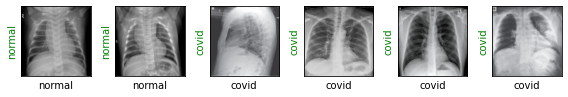

In [15]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

___

<a id='section9'></a>
## 9. Creating the Model

In [31]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- We initialize our pretrained Restnet18 model by using the torchvision library.

In [32]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3) # fc is the keyword at the end when we run the above cell
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(),lr = 3e-5)

As we can see, the output of the pretrained Resnet18 model has 1000 features. We do not require the output to be in this format so we use the Linear method in order to apply the linear transformation and be left with only 3 outputs as we require.

We also set our loss function as Cross Entropy loss and our optimizer to the Adam optimizer which is a variant of SGD.

In [33]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

The show_preds method is used to iterate through our batches, pass these batches one at a time to the resnet18 method and displays them.

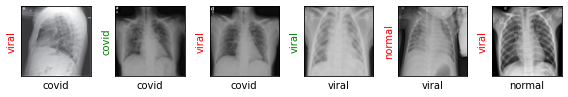

In [34]:
show_preds()

___

<a id='section10'></a>
## 10. Training the Model

In [35]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.97:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

- We set the resnet18 model to training mode. We then iterate through the training set and after setting the gradients to zero, we get our outputs from the restnet18 model and our loss value.
- We then switch the resnet18 model to evaluate mode and iterate through out test set. Similarly we calculate the validation loss and create our predictions.
- Lastly we calculate the final accuracy of our model and call the show_preds() function and set the model back to training mode.
- In the last step, we have a condition to stop when our performance condition is met.

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1505, Accuracy: 0.3222


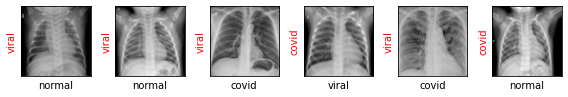

Evaluating at step 20
Validation Loss: 0.5708, Accuracy: 0.8778


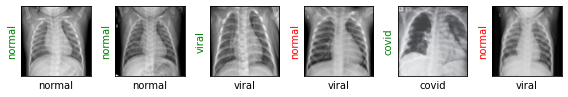

Evaluating at step 40
Validation Loss: 0.3985, Accuracy: 0.8667


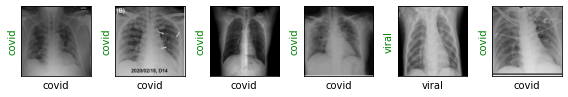

Evaluating at step 60
Validation Loss: 0.2482, Accuracy: 0.9222


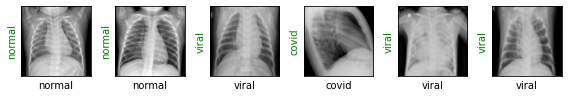

Evaluating at step 80
Validation Loss: 0.2042, Accuracy: 0.9444


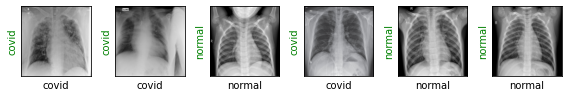

Evaluating at step 100
Validation Loss: 0.1726, Accuracy: 0.9556


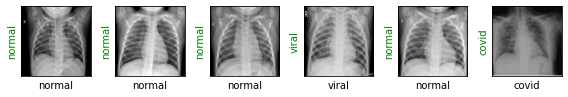

Evaluating at step 120
Validation Loss: 0.2432, Accuracy: 0.9000


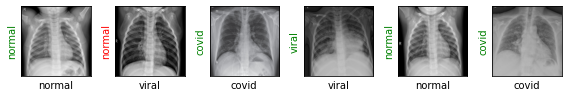

Evaluating at step 140
Validation Loss: 0.1137, Accuracy: 0.9556


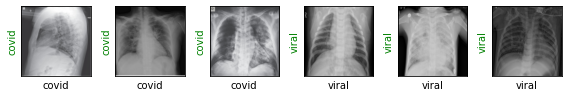

Evaluating at step 160
Validation Loss: 0.2587, Accuracy: 0.8667


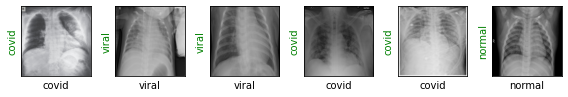

Evaluating at step 180
Validation Loss: 0.2824, Accuracy: 0.8778


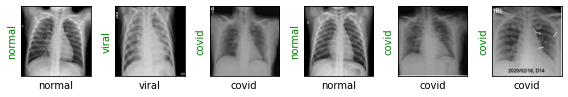

Evaluating at step 200
Validation Loss: 0.2397, Accuracy: 0.8889


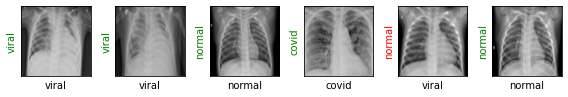

Evaluating at step 220
Validation Loss: 0.1839, Accuracy: 0.9333


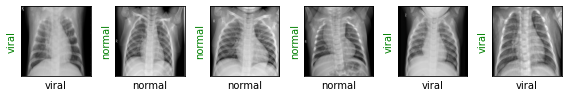

Evaluating at step 240
Validation Loss: 0.1021, Accuracy: 0.9778


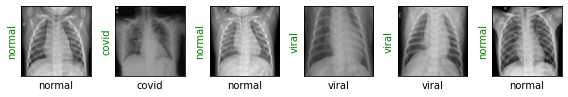

Performance condition satisfied, stopping..


In [36]:
train(epochs = 1)

Finally, we call the __train()__ method and set the number of epochs to 1. This will train our model and we will evaluate our performance at every 20 training steps.

___

<a id='section11'></a>
## 11. Final Results

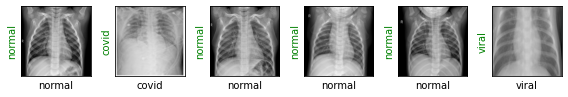

In [26]:
show_preds()

We can view our results by calling the show_preds() method. This will show us individual batches of our predictions.

<a id='section12'></a>
## 12. Conclusion

- In this notebook, we used various libraries such as torch and pillow in order to classify chest X-rays as viral, normal or COVID-19.
- We have made use of packages like numpy to help us better handle matrix operations.
- In this project, we are using the pretrained Resnet18 model to classify these images.
- The images are augmented, normalized and resized in order for the Resnet18 model to accept them as input.
- We prepare our dataloader after deciding on a batch size and creating our transformed images.
- The model is then modified to give us the correct number of outputs that we require as the output that the pretrained Resnet18 gives us, does not fit our requirements.
- The model is trained and we observe how the accuracy and loss validation loss changes across the training steps.

___

<a id='section13'></a>
## 13. Ackowledgements

__Dataset :__
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

___